# Libraries

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [ ]:
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(720, 480))
display.start()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
import gym
import numpy as np
import random
import time

# Utils

In [ ]:
def play(env, q_table, render=False):
    state = env.reset()
    total_reward = 0
    steps = 0
    done = False

    if render:
        plt.axis('off')
        
    while not done:
        action = np.argmax(q_table[state, :])
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        steps += 1
        if render:
            print(f"{state} --> {next_state}")
            time.sleep(0.5)
            screen = env.render(mode='rgb_array')
            plt.imshow(screen)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
            time.sleep(0.5)

        state = next_state

    return (total_reward, steps)

In [ ]:
def play_multiple_times(env, q_table, max_episodes):
    success = 0
    list_of_steps = []
    for i in range(max_episodes):
        total_reward, steps = play(env, q_table)

        if total_reward > 0:
            success += 1
            list_of_steps.append(steps)

    print(f'Number of successes: {success}/{max_episodes}')
    print(f'Average number of steps: {np.mean(list_of_steps)}')

In [ ]:
def plot_graph(rewards_all_Q, rewards_all_S):
    window = 100

    average_y_Q = []
    average_y_S = []

    for ind in range(len(rewards_all_Q) - window + 1):
        average_y_Q.append(np.mean(rewards_all_Q[ind:ind+window]))
        average_y_S.append(np.mean(rewards_all_S[ind:ind+window]))

        
    for ind in range(window - 1):
        average_y_Q.insert(0, np.nan)
        average_y_S.insert(0, np.nan)

    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(rewards_all_Q)), average_y_Q, color='magenta', label='Q-Learning')
    plt.plot(np.arange(len(rewards_all_S)), average_y_S, color='brown', label='SARSA')
    plt.yticks([0, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    plt.grid()
    plt.xlabel('Episodes')
    plt.ylabel(f'Average over {window} episodes')
    plt.legend()
    plt.show()

In [ ]:
def take_action(epsilon, q_table, state):
    # Randomly initialize exploration scalar and compare it with epsilon
    exploration = random.uniform(0,1)
    
    if exploration < epsilon: # randomly taking action
        action = env.action_space.sample()
    else: # Taking action based on argmax
        action = np.argmax(q_table[state, :])

    return action

# Q-Learning

In [ ]:
def q_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate):
    # Initialize Q_table 
    q_table = np.zeros((env.observation_space.n, env.action_space.n))

    rewards_all = []

    # Loop throuch each episode
    for episode in range(num_episodes):
        # Reset environment
        state = env.reset()

        reward_episode = 0.0
        done = False
        
        # Compute epsilon for exploration
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate * episode)

        # Loop throuch each step in episode
        for step in range(num_steps_per_episode):

            # Take action
            action = take_action(epsilon, q_table, state)

            # Perform action and go to next state
            next_state, reward, done, info = env.step(action)

            # Update Q_table 
            q_table[state, action] = q_table[state, action] * (1 - learning_rate) + learning_rate * \
                                                (reward + gamma * np.max(q_table[next_state,:]))
                                     
            # Accumulate reward in this episode
            reward_episode += reward

            state = next_state

            # If game is done then break            
            if done:
                break
        # Store rewards of all episode
        rewards_all.append(reward_episode)

    # print(f'Episode {episode} finished')
    return q_table, rewards_all

# SARSA

In [ ]:
def sarsa(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate):
    # Initialize Q_table 
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_all = []

    # Loop throuch each episode
    for episode in range(num_episodes):
        # Reset environment
        state = env.reset()

        reward_episode = 0.0
        done = False
        
        # Compute epsilon for exploration
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate*episode)
        
        # Taking action a
        action = take_action(epsilon, q_table, state)

        # Loop throuch each step in episode
        for step in range(num_steps_per_episode):
            # Perform action a
            next_state, reward, done, info = env.step(action)

            # Taking action a'
            next_action = take_action(epsilon, q_table, next_state)
            
            # Update Q_table 
            q_table[state, action] = q_table[state, action] + learning_rate * \
                                            (reward + gamma * q_table[next_state, next_action] - q_table[state, action])

            # Accumulate reward in this episode
            reward_episode += reward

            state = next_state
            action = next_action

            # If game is done then break            
            if done:
                break

        # Store rewards of all episode
        rewards_all.append(reward_episode)
        
    # print(f'Episode {episode} finished')
    return q_table, rewards_all

# Results

## FrozenLake-v1

In [ ]:
env = gym.make('FrozenLake-v1')

# Hyperparameters
GAMMA = 0.99
LEARNING_RATE = 0.1
MAX_EPSILON = 1.0
MIN_EPSILON = 0.01
EPSILON_DECAY_RATE = 0.005

NUM_EPISODES = 20000
NUM_STEPS_PER_EPISODE = 100

In [ ]:
start = time.time()
q_table_Q, rewards_all_Q = q_learning(env, NUM_EPISODES, NUM_STEPS_PER_EPISODE, LEARNING_RATE, GAMMA, MAX_EPSILON, MIN_EPSILON, EPSILON_DECAY_RATE)
print(f'Run time: {time.time() - start}')

Run time: 30.03850030899048


In [ ]:
start = time.time()
q_table_S, rewards_all_S = sarsa(env, NUM_EPISODES, NUM_STEPS_PER_EPISODE, LEARNING_RATE, GAMMA, MAX_EPSILON, MIN_EPSILON, EPSILON_DECAY_RATE)
print(f'Run time: {time.time() - start}')

Run time: 23.15394926071167


In [ ]:
print(f'Q_Learning sum reward : {sum(rewards_all_Q)}')
print(f'SARSA sum reward: {sum(rewards_all_S)}')

Q_Learning sum reward : 12871.0
SARSA sum reward: 13160.0


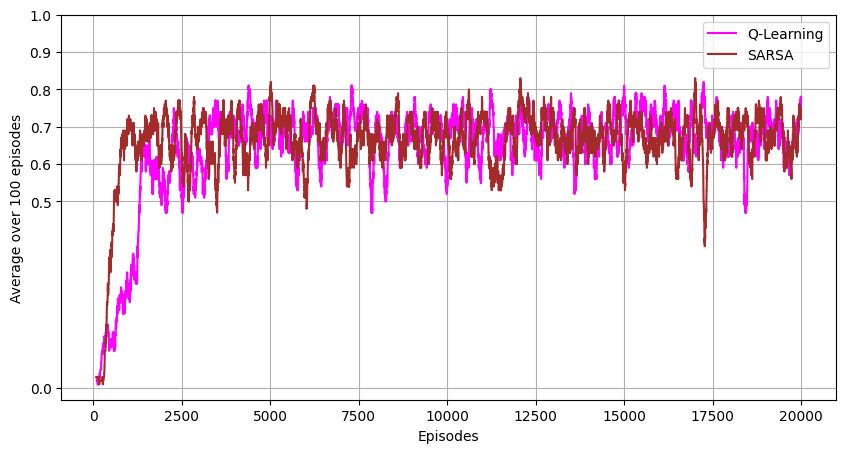

In [ ]:
plot_graph(rewards_all_Q, rewards_all_S)

In [ ]:
play_multiple_times(env, q_table_Q, 1000)

Number of successes: 731/1000
Average number of steps: 36.562243502051984


In [ ]:
play_multiple_times(env, q_table_S, 1000)

Number of successes: 759/1000
Average number of steps: 39.01449275362319


## FrozenLake8x8-v1

In [ ]:
env = gym.make('FrozenLake8x8-v1')

# Hyperparameters
GAMMA = 0.99
LEARNING_RATE = 0.01
MAX_EPSILON = 1.0
MIN_EPSILON = 0.01
EPSILON_DECAY_RATE = 0.0001

NUM_EPISODES = 20000
NUM_STEPS_PER_EPISODE = 1000

In [ ]:
start = time.time()
q_table_Q, rewards_all_Q = q_learning(env, NUM_EPISODES, NUM_STEPS_PER_EPISODE, LEARNING_RATE, GAMMA, MAX_EPSILON, MIN_EPSILON, EPSILON_DECAY_RATE)
print(f'Run time: {time.time() - start}')

Run time: 41.97943449020386


In [ ]:
start = time.time()
q_table_S, rewards_all_S = sarsa(env, NUM_EPISODES, NUM_STEPS_PER_EPISODE, LEARNING_RATE, GAMMA, MAX_EPSILON, MIN_EPSILON, EPSILON_DECAY_RATE)
print(f'Run time: {time.time() - start}')

Run time: 25.8737313747406


In [ ]:
print(f'Q_Learning sum reward : {sum(rewards_all_Q)}')
print(f'SARSA sum reward: {sum(rewards_all_S)}')

Q_Learning sum reward : 2049.0
SARSA sum reward: 737.0


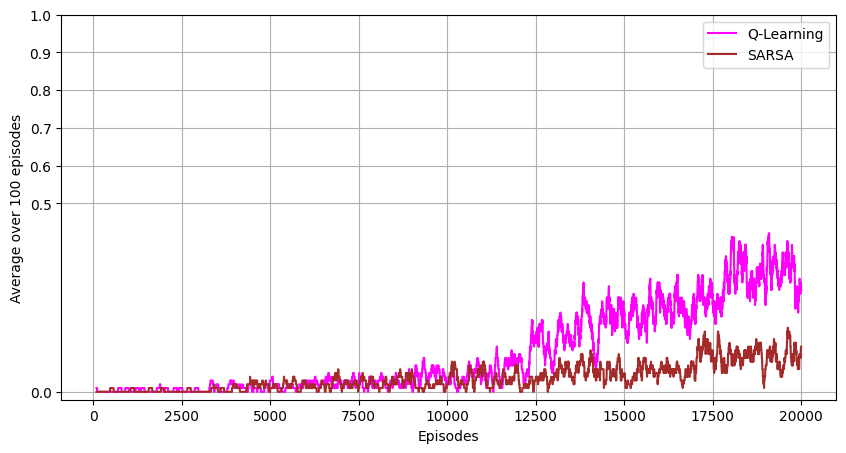

In [ ]:
plot_graph(rewards_all_Q, rewards_all_S)

In [ ]:
play_multiple_times(env, q_table_Q, 1000)

Number of successes: 179/1000
Average number of steps: 53.58659217877095


In [ ]:
play_multiple_times(env, q_table_S, 1000)

Number of successes: 164/1000
Average number of steps: 61.01219512195122


## Taxi-v3

In [ ]:
env = gym.make('Taxi-v3')

# Hyperparameters
GAMMA = 0.99
LEARNING_RATE = 0.1
MAX_EPSILON = 1.0
MIN_EPSILON = 0.01
EPSILON_DECAY_RATE = 0.005

NUM_EPISODES = 20000
NUM_STEPS_PER_EPISODE = 100

In [ ]:
start = time.time()
q_table_Q, rewards_all_Q = q_learning(env, NUM_EPISODES, NUM_STEPS_PER_EPISODE, LEARNING_RATE, GAMMA, MAX_EPSILON, MIN_EPSILON, EPSILON_DECAY_RATE)
print(f'Run time: {time.time() - start}')

Run time: 19.325448274612427


In [ ]:
start = time.time()
q_table_S, rewards_all_S = sarsa(env, NUM_EPISODES, NUM_STEPS_PER_EPISODE, LEARNING_RATE, GAMMA, MAX_EPSILON, MIN_EPSILON, EPSILON_DECAY_RATE)
print(f'Run time: {time.time() - start}')

Run time: 15.514766931533813


In [ ]:
print(f'Q_Learning sum reward : {sum(rewards_all_Q)}')
print(f'SARSA sum reward: {sum(rewards_all_S)}')

Q_Learning sum reward : 3519.0
SARSA sum reward: 6552.0


In [ ]:
play_multiple_times(env, q_table_Q, 1000)

Number of successes: 1000/1000
Average number of steps: 13.204


In [ ]:
play_multiple_times(env, q_table_S, 1000)

Number of successes: 1000/1000
Average number of steps: 13.029


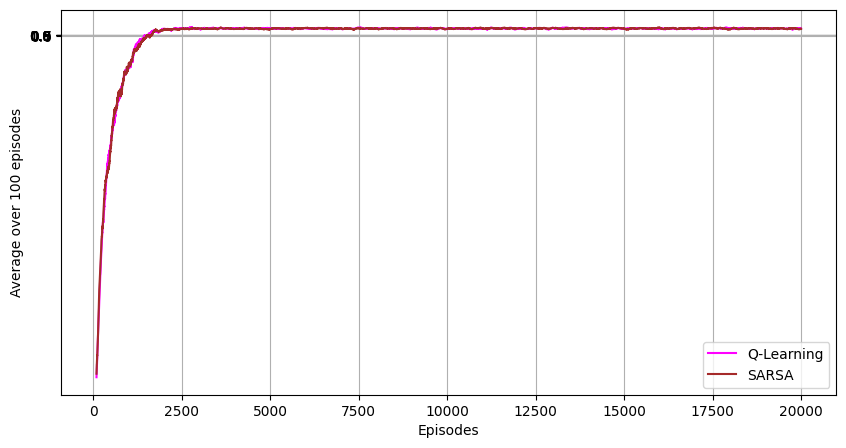

In [ ]:
plot_graph(rewards_all_Q, rewards_all_S)

# Conclusion


*   FrozenLake

$
\begin{array}{||c|c|c|} \hline
                & Run time (s)  & Sum\hspace{1mm}of\hspace{1mm}Rewards  \\ \hline
QL              & 30.04 & 12871.0  \\
SARSA           & 23.15 & 13160.0  \\ \hline
\end{array}
$

</br>
</br>

*   FrozenLake8x8

$
\begin{array}{||c|c|c|} \hline
                & Run time (s)  & Sum\hspace{1mm}of\hspace{1mm}Rewards \\ \hline
QL              & 35.21 & 942  \\
SARSA           & 22.46 & 515  \\ \hline
\end{array}
$

</br>
</br>

*   Taxi

$
\begin{array}{||c|c|c|} \hline
                & Run time (s)  & Sum\hspace{1mm}of\hspace{1mm}Rewards  \\ \hline
QL              & 19.32 & 3519.0  \\
SARSA           & 15.51 & 6552.0  \\ \hline
\end{array}
$

Based on the performance of 2 algorithms in 3 games:
* QL takes more time to complete
* In Taxi-v3, SARSA has more rewards but according to the graph, both QL and SARSA performance is not different from each other
* In FrozenLake, SARSA has better performance in the early of the training, but from episode 2500, it is not different from QL
* In FrozenLake8x8, it is hard to find hyperparameters that suit both algorithms, for temporary we can say that QL has better performance


In conclusion, based on 3 games we see that SARSA has a better performance than QL. It also depends on the game (environment) and hyperparameters to have the best conclusion